# Overview FEMA Spending

## Input Files:
- HELP HELP.xlsx

## Output Files:
- fema_fed_by_month.xlsx
- fema_state_by_month.xlsx
- fema_total_by_month.xlsx

## Error Files:
- fema_err_start_date.csv
- fema_err_end_date.csv
- fema_err_start_date_gt_end_date.csv
- fema_err_total_spend.csv
- fema_err_fed_spend.csv
- fema_err_state_spend.csv


## Preliminaries

In [1]:
# set to true to create output files again
create_output_files = False
chunk_size = 200000
#chunk_size = 100000
#chunk_size = 50000
#chunk_size = 10000
#chunk_size=2

In [2]:
import pandas as pd
import numpy as np
import re
import glob
import os
import pickle
import datetime
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from scipy.stats import rvs_ratio_uniforms
from sympy import *
import sympy
import scipy.stats as stats

### Files and Directories

In [3]:
# Base
#base_dir = "./Rich"
base_dir = '/content/drive/MyDrive/environment'
out_dir = os.path.join(base_dir,"out2")

# FEMA
fema_in_file = "HELP HELP.xlsx"
#fema_in_file = "HELP HELP2.xlsx"
fema_fed_out_file = "fema_fed_by_month"     # .csv or xlsx added later
fema_st_out_file = "fema_state_by_month"    # .csv or xlsx added later
fema_tot_out_file = "fema_total_by_month"   # .csv or xlsx added later

fema_err_dt1_out_file = "fema_err_start_date.csv"
fema_err_dt2_out_file = "fema_err_end_date.csv"
fema_err_dt2_lt_dt1_file = "fema_err_start_date_gt_end_date.csv"
fema_err_tot_spend = "fema_err_total_spend.csv"
fema_err_fed_spend = "fema_err_fed_spend.csv"
fema_err_st_spend = "fema_err_state_spend.csv"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Distributions for Model Spending

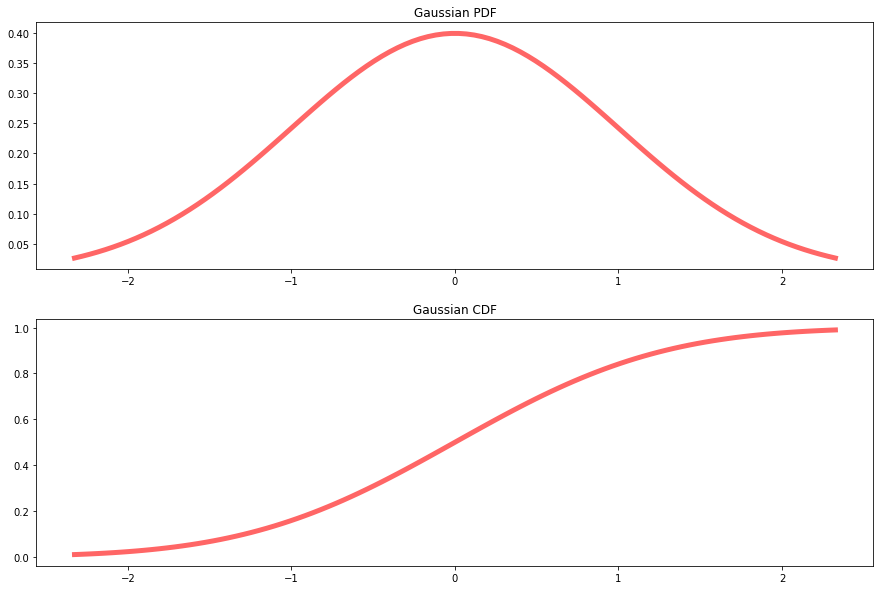

In [5]:
fig, ax = plt.subplots(2, 1)
fig.set_figheight(10)
fig.set_figwidth(15)
x = np.linspace(stats.norm.ppf(0.01),stats.norm.ppf(0.99), 100)
ax[0].plot(x, stats.norm.pdf(x),'r-', lw=5, alpha=0.6, label='norm pdf')
ax[0].set_title("Gaussian PDF")
ax[1].plot(x, stats.norm.cdf(x),'r-', lw=5, alpha=0.6, label='norm cdf')
ax[1].set_title("Gaussian CDF")
plt.show()

0.08392401699487584
3.986075498056125e-06
11915.540220876905
1000.0


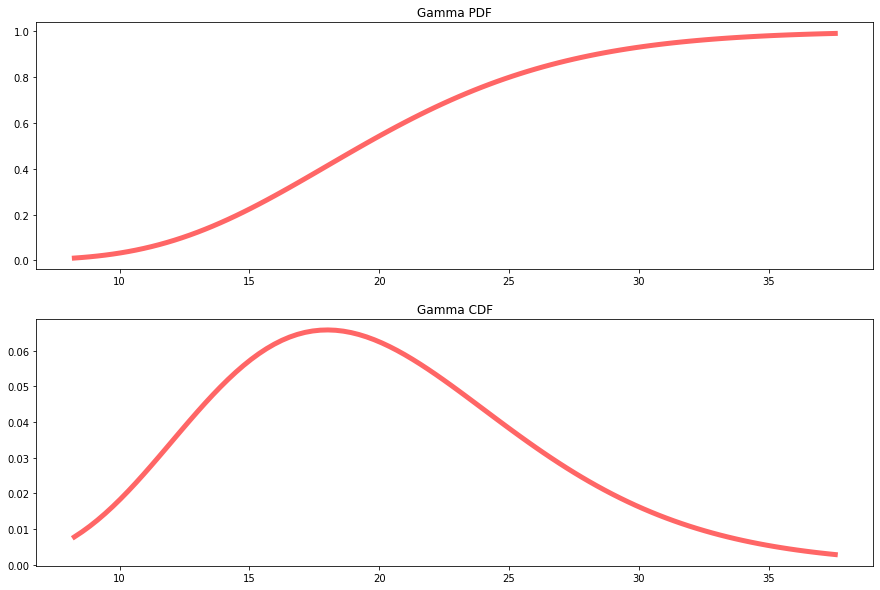

In [6]:
fig, ax = plt.subplots(2, 1)
fig.set_figheight(10)
fig.set_figwidth(15)
#a = 1.99
#gamma_max = 15
a = 10
gamma_max = 40
beta_inv = 2
gamma_cover = stats.gamma.cdf(gamma_max,a,scale=beta_inv)
x = np.linspace(stats.gamma.ppf(0.01, a, scale=beta_inv),
                stats.gamma.ppf(0.99, a, scale=beta_inv), 100)
ax[0].plot(x, stats.gamma.cdf(x, a, scale=beta_inv),'r-', lw=5, alpha=0.6, 
        label='gamma pdf')
ax[0].set_title("Gamma PDF")
ax[1].plot(x, stats.gamma.pdf(x, a, scale=beta_inv),'r-', lw=5, alpha=0.6, 
        label='gamma pdf')
ax[1].set_title("Gamma CDF")

print(stats.gamma.cdf(12,a,scale=beta_inv))
print(stats.gamma.cdf(3,a,scale=beta_inv)-stats.gamma.cdf(2,a,scale=beta_inv))
print(1000/stats.gamma.cdf(12,a,scale=beta_inv))
val = 1000/gamma_cover
print((stats.gamma.cdf(gamma_max/4,a,scale=beta_inv) + \
       (stats.gamma.cdf(gamma_max/2,a,scale=beta_inv) - \
        stats.gamma.cdf(gamma_max/4,a,scale=beta_inv)) + \
       (stats.gamma.cdf(3*gamma_max/4,a,scale=beta_inv) - \
        stats.gamma.cdf(gamma_max/2,a,scale=beta_inv)) + \
       (stats.gamma.cdf(gamma_max,a,scale=beta_inv) - \
        stats.gamma.cdf(3*gamma_max/4,a,scale=beta_inv)))*val) 
plt.show()

## Process FEMA

In [7]:
def clean_up_file(filename):
    filepath = os.path.join(base_dir,filename)
    if os.path.exists(filepath):
        print(F"removing {filepath}...")
        os.remove(filepath)

In [8]:
def clean_up_files(filename,ext):
    file_list = glob.glob(os.path.join(base_dir,F"{filename}_*.{ext}"))
    for filepath in file_list:
        print(F"removing {filepath}...")
        os.remove(filepath)

In [9]:
# clean_up_file(F"{fema_fed_out_file}.xlsx")
# clean_up_file(F"{fema_st_out_file}.xlsx")
# clean_up_file(F"{fema_tot_out_file}.xlsx")
# clean_up_file(F"{fema_fed_out_file}.csv")
# clean_up_file(F"{fema_st_out_file}.csv")
# clean_up_file(F"{fema_tot_out_file}.csv")
clean_up_files(fema_fed_out_file,"csv")
clean_up_files(fema_st_out_file,"csv")
clean_up_files(fema_tot_out_file,"csv")
clean_up_file(fema_err_dt1_out_file)
clean_up_file(fema_err_dt2_out_file)
clean_up_file(fema_err_dt2_lt_dt1_file)
clean_up_file(fema_err_tot_spend)
clean_up_file(fema_err_fed_spend)
clean_up_file(fema_err_st_spend)

removing /content/drive/MyDrive/environment/fema_fed_by_month_0.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_1.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_2.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_3.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_4.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_5.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_6.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_7.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_8.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_9.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_10.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_11.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_12.csv...
removing /content/drive/MyDrive/environment/fema_fed_by_month_13.csv...
re

In [10]:
dffema = None   # master set
dti = None
df = None       # chunk set
use_gaussian = True
cdfbins = 1000
cdftot = 1000000
cdf = None

In [11]:
def clean():
    global dffema

    # set non-numeric years or months to 0
    dffema["START YR"] = \
        pd.to_numeric(dffema["START YR"], \
                      errors='coerce').fillna(0).astype('int')
    dffema["START MO"] = \
        pd.to_numeric(dffema["START MO"], \
                      errors='coerce').fillna(0).astype('int')
    dffema["END YR"] = \
        pd.to_numeric(dffema["END YR"], \
                      errors='coerce').fillna(0).astype('int')
    dffema["END MO"] = \
        pd.to_numeric(dffema["END MO"], \
                      errors='coerce').fillna(0).astype('int')
    
    # set end date to match start date in the case where end month was zero 
    # or was originally non-numeric (which was set to 0 above)
    baddates = (dffema["END MO"]==0)
    dffema.loc[baddates,"END YR"] = dffema[baddates]["START YR"]
    dffema.loc[baddates,"END MO"] = dffema[baddates]["START MO"]

    # record rows with bad start dates to an error file
    dferr = dffema[pd.to_datetime(dffema["START MO"].astype(str) + " " \
                                    + dffema["START YR"].astype(str), 
                                    errors="coerce").isna()]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt1_out_file))

    # record rows with bad end dates to an error file
    dferr = dffema[pd.to_datetime(dffema["END MO"].astype(str) + " " \
                                    + dffema["END YR"].astype(str),
                                    errors="coerce").isna()]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt2_out_file))

    # remove rows with bad start dates and bad end dates from dataframe
    dffema = dffema[pd.to_datetime(dffema["START MO"].astype(str) + \
                                    " " + dffema["START YR"].astype(str), 
                                    errors="coerce").notna()]
    dffema = dffema[pd.to_datetime(dffema["END MO"].astype(str) + \
                                    " " + dffema["END YR"].astype(str),
                                    errors="coerce").notna()]

    # record rows with end date < start dates to error file
    dferr = dffema[(pd.to_datetime(dffema['END YR'].astype(str) \
                                   + " "+dffema['END MO'].astype(str))) \
                   < (pd.to_datetime(dffema['START YR'].astype(str) \
                                     + " " + dffema['START MO'].astype(str)))]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt2_lt_dt1_file))

    # remove rows with end date < start date from dataframe
    dffema = dffema[(pd.to_datetime(dffema['END YR'].astype(str) \
                                   + " "+dffema['END MO'].astype(str))) \
                   >= (pd.to_datetime(dffema['START YR'].astype(str) \
                                     + " " + dffema['START MO'].astype(str)))]
    
    # set non-numeric SPEND values to 0 
    dffema["TOTAL PROJECT SPEND"] = \
        pd.to_numeric(dffema["TOTAL PROJECT SPEND"], \
                      errors='coerce').fillna(0).astype('float').round(2)
    dffema["FED SPEND"] = \
        pd.to_numeric(dffema["FED SPEND"], \
                      errors='coerce').fillna(0).astype('float').round(2)
    dffema["STATE SPEND"] = \
        pd.to_numeric(dffema["STATE SPEND"], \
                      errors='coerce').fillna(0).astype('float').round(2)

In [12]:
def create_dates_index():
    global dffema
    global dti
    dti = pd.date_range(start=pd.to_datetime(dffema["START MO"].astype(str) + \
                                            " " + dffema["START YR"].astype(str)).min(),
                        end=pd.to_datetime(dffema["END MO"].astype(str) + \
                                            " " + dffema["END YR"].astype(str),
                                            format="%m %Y").max()+MonthEnd(0),
                        freq='M').strftime("%Y-%m")

In [13]:
# def build_gassian_prototype():
#     global cdf
#     seed = 47563
#     rng = np.random.default_rng(seed)

#     mu = cdfbins/2
#     sigma = cdfbins/6
    
#     a, b = (0 - mu) / sigma, ((cdfbins-1) - mu) / sigma
    
#     cdf = stats.truncnorm.rvs(a,b,loc=mu,scale=sigma,
#                               size=cdftot,random_state=rng).round().astype(int)
#     _ = plt.hist(cdf,bins=np.arange(cdfbins))
#     cdf = np.bincount(cdf)
#     for i in np.arange(cdfbins):
#          if i == 0:
#              continue
#          cdf[i] += cdf[i-1]

In [14]:
# build_gassian_prototype()

In [15]:
dffema = pd.DataFrame(pd.read_excel(os.path.join(base_dir,fema_in_file),
                                    header=1,
                                    sheet_name='HELP',
                                    usecols=np.arange(12).tolist()))

In [16]:
headers = dffema.columns
dummy_index = dffema.index[-1]+1
clean()
create_dates_index()
display(dffema)
dffema_len = len(dffema)
df_orig = None
df = None

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1.0,1039431.28,1039431.28,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1.0,2664.51,1998.38,666.13
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1.0,22914.27,17185.70,5728.57
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1.0,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1.0,70000.00,70000.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
950542,HOUSING ASSISTANCE RENTERS,NaN,53216,WI,2010,8,2010,8,NaN,0.00,3361725.14,0.00
950543,HOUSING ASSISTANCE RENTERS,NaN,53218,WI,2010,8,2010,8,NaN,0.00,3753216.85,0.00
950544,HOUSING ASSISTANCE RENTERS,NaN,53209,WI,2010,8,2010,8,NaN,0.00,4084102.26,0.00
950545,HOUSING ASSISTANCE RENTERS,NaN,53206,WI,2010,8,2010,8,NaN,0.00,4770400.99,0.00


In [17]:
def create_spend_report(display_result=True,
                        save=False,
                        verbose=True,
                        test_sums=False,
                        n=0):
    global df
    # update single month
    criteria = (df["months"]==1)
    df.loc[criteria,"spendtot"] = df[criteria]["TOTAL PROJECT SPEND"]
    df.loc[criteria,"spendfed"] = df[criteria]["FED SPEND"]
    df.loc[criteria,"spendst"] = df[criteria]["STATE SPEND"]

    # map proportion needed to the proportion of the cdf
    #stats.gamma.cdf(gamma_max/4,a,scale=beta_inv
    # cdffunc = lambda x, s: (round((stats.gamma.cdf(((x["mindex"]+1)/x['months']).astype("float")*gamma_max,
    #                                                a, scale=beta_inv) - \
    #                            stats.gamma.cdf((x["mindex"]/x["months"]).astype("float")*gamma_max,
    #                                            a, scale=beta_inv))*(x[s]/gamma_cover),2))
    # #cdffunc = lambda x: cdffunc1(x,colspend)
    # cdffunctot = lambda x: cdffunc(x,"TOTAL PROJECT SPEND")
    # cdffuncfed = lambda x: cdffunc(x,"FED SPEND")
    # cdffuncst = lambda x: cdffunc(x,"STATE SPEND")

    if verbose:
        print("distributing spend value over time period...")
    criteria = (df["months"]>1)
    df.loc[criteria,"spendtot"] = round(df[criteria]["TOTAL PROJECT SPEND"]*df[criteria]["fraction"],2)
    df.loc[criteria,"spendfed"] = round(df[criteria]["FED SPEND"]*df[criteria]["fraction"],2)
    df.loc[criteria,"spendst"] = round(df[criteria]["STATE SPEND"]*df[criteria]["fraction"],2)

    # df.loc[criteria,"spendtot"] = df[criteria].apply(cdffunctot,axis=1)
    # df.loc[criteria,"spendfed"] = df[criteria].apply(cdffuncfed,axis=1)
    # df.loc[criteria,"spendst"] = df[criteria].apply(cdffuncst,axis=1)

    if verbose:
        print("correcting rounding errors...")
    # adjust "middle" element to compensate for rounding error
    def adjust(colspend,spend):
        tmp = pd.DataFrame(df[df["months"]>1].groupby(axis=0,level=0)[spend].sum())
        df.loc[(df["months"]>1) \
               & (df["mindex"] == (df["months"]/2).astype(int)),spend] += \
                (df[(df["months"]>1) \
                    & (df["mindex"] \
                       == (df["months"]/2).astype(int))][colspend] - tmp[spend]).round(2)
    adjust("TOTAL PROJECT SPEND","spendtot")
    adjust("FED SPEND","spendfed")
    adjust("STATE SPEND","spendst")

    def test(colspend,spend):
        if test_sums:
            tmp = pd.DataFrame(df[df["months"]>1].groupby(axis=0,level=0)[spend].sum())
            tmp2 = df[(df["months"]>1) & (df["mindex"]==1)]
            tmp3 = tmp2[((tmp2[colspend]-tmp[spend]).abs().round(2))>0.0]
            if len(tmp3) != 0:
                print("The following rows failed the test...")
                display(tmp3)
            elif verbose:
                print("Passed!")
    test("TOTAL PROJECT SPEND","spendtot")
    test("FED SPEND","spendfed")
    test("STATE SPEND","spendst")

    if verbose:
        print("dropping obsolete columns...")
    # dispose of columns no longer needed
    df = df.drop(["TOTAL PROJECT SPEND","FED SPEND",
                          "STATE SPEND","months","mindex"],axis=1)

    if verbose:
        print("appending dummy row to cover date range...")
    # add dummy data, so that even date columns without data will be created
    # this row will not be included in final result since index will not match
    # any index in df_orig, but it will keep the columns, which is the point
    #df = df.append(pd.DataFrame({"range":dti,"spend":0.0},
    df = df.append(pd.DataFrame({"range":dti,
                                 "spendtot":0.0,"spendfed":0.0,"spendst":0.0},
                                        index=np.ones(shape=len(dti),dtype=int)*dummy_index,
                                        columns=["range",
                                                 "spendtot",
                                                 "spendfed",
                                                 "spendst"]))
    
    def pivot_and_save(spend,filename):
        #global df
        if verbose:
            print(F"pivoting {spend} column...")
        # pivot spend to date columns
        df2 = df.pivot(values=spend,columns="range")
        df2.columns.name = ""
    
        if verbose:
            print(F"joining {spend} data with original data...")
        # rejoin with original data
        df2 = df_orig.join(df2)
        
        if display_result:
            display(df2)

        if save:
            #filepath = os.path.join(base_dir,F"{filename}.csv")
            filepath = os.path.join(base_dir,F"{filename}_{n}.csv")

            if verbose:
                print(F"writing to {filepath}...")
            rec_count = len(df2)
            if rec_count > 0:
                df2.to_csv(filepath, header=True, mode="w")
                print(F"created {filepath} with {len(df2)} record{'s' if rec_count>1 else ''}")
            elif verbose:
                print(F"no records to write to {filepath}")
            # exists = os.path.exists(filepath)
            # rec_count = len(df2)
            # if rec_count > 0:
            #     df2.to_csv(filepath, header=not exists, mode="a" if exists else "w")
            #     if exists:
            #         print(F"appended {len(df2)} record{'s' if rec_count>1 else ''} to {filepath}")
            #     else:
            #         print(F"created {filepath} with {len(df2)} record{'s' if rec_count>1 else ''}")
            # elif verbose:
            #     print(F"no records to write to {filepath}")
            # unfortunately, writing to xlsx is too slow
            # filepath = os.path.join(base_dir,F"{filename}_{n}.xlsx")
            # print(F"writing to {filepath}...")
            # df2.to_excel(filepath, header=True)
            # print(F"{filepath} created!")
    
    pivot_and_save("spendtot",fema_tot_out_file)
    pivot_and_save("spendfed",fema_fed_out_file)
    pivot_and_save("spendst",fema_st_out_file)

In [18]:
def prep(copy_orig=True):
    global df
    if copy_orig:
        df = df_orig.copy()

    # add range column (list of n months from start to end, formate YYYY-MM)
    dt1 = pd.to_datetime(df["START MO"].astype(str) + " " \
                         + df["START YR"].astype(str))
    dt2 = pd.to_datetime(df["END MO"].astype(str) + " " \
                         + df["END YR"].astype(str)) + MonthEnd(0)
    df["range"] = [pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist() \
                   for a, b in zip(dt1, dt2)]

    # add months column (n, single number per row, not a list)
    df["months"] = df["range"].apply(len)

    # add mindex column (0 to n-1)
    df["mindex"] = df["months"].apply(np.arange)

    # add spend column (list of n 0.0's, placeholder for the calculated spend later
    df["spend"] = df["months"].apply(np.zeros)

    # drop all but the above 4 columns + index
    df = df.drop(["FUND SOURCE","TYPE","COUNTY","STATE","START YR",\
                  "START MO","END YR","END MO","NUMBER OF MONTHS"],axis=1)

    # explode date, index and spend (each is a list with n elements)
    df = df.explode(["range","mindex","spend"])
    df["spend"] = df["spend"].astype(float)

    # add fraction column
    #print("test")
    #display(df["mindex"])
    cdffunc = lambda x: ((stats.gamma.cdf(((x["mindex"]+1)/x['months']).astype("float")*gamma_max,
                                          a, scale=beta_inv) - \
                          stats.gamma.cdf((x["mindex"]/x["months"]).astype("float")*gamma_max,
                                          a, scale=beta_inv))/gamma_cover)
    df["fraction"] = df.apply(cdffunc,axis=1).astype(float)

    #df["fraction"] = ((1/df["months"]).astype(float) * cdfbins).astype(int)

In [19]:
#display(dffema)

In [20]:
# n = 1
# df = dffema[(dffema.index >= n*chunk_size) \
#             & (dffema.index < (n+1)*chunk_size)].copy()

# prep()
# colspend = "TOTAL PROJECT SPEND"
# df.loc[df["months"]==1,"spend"] = df[df["months"]==1][colspend]

# # map proportion needed to the proportion of the cdf
# #stats.gamma.cdf(gamma_max/4,a,scale=beta_inv
# cdffunc = lambda x: (round((stats.gamma.cdf(((x["mindex"]+1)/x['months']).astype("float")*gamma_max,
#                                             a, scale=beta_inv) - \
#                             stats.gamma.cdf((x["mindex"]/x["months"]).astype("float")*gamma_max,
#                                             a, scale=beta_inv))*x[colspend],2))
    
# # update first month in multi-month
# criteria = (df["months"]>1)
# df.loc[criteria,"spend"] = df[criteria].apply(cdffunc,axis=1)

In [21]:
test = True
if dffema_len > 0:
    n=0
    while True:
        df = dffema[(dffema.index >= n*chunk_size) \
                    & (dffema.index < (n+1)*chunk_size)].copy()
        rec_count = len(df)
        # save space by making the master frame smaller as you go
        dffema = dffema[dffema.index >= (n+1)*chunk_size] 
        if rec_count > 0:
            df_orig = df.copy()
            prep(copy_orig=False)
            create_spend_report(test_sums=test,
                                display_result=False,
                                save=True,
                                verbose=False,
                                n=n)
        print(F"iteration {n+1}: {rec_count} record{'s' if rec_count>1 else ''} processed")
        print("")
        n += 1
        if n*chunk_size > (dffema_len-1):
            break

created /content/drive/MyDrive/environment/fema_total_by_month_0.csv with 200000 records
created /content/drive/MyDrive/environment/fema_fed_by_month_0.csv with 200000 records
created /content/drive/MyDrive/environment/fema_state_by_month_0.csv with 200000 records
iteration 1: 200000 records processed

created /content/drive/MyDrive/environment/fema_total_by_month_1.csv with 200000 records
created /content/drive/MyDrive/environment/fema_fed_by_month_1.csv with 200000 records
created /content/drive/MyDrive/environment/fema_state_by_month_1.csv with 200000 records
iteration 2: 200000 records processed

created /content/drive/MyDrive/environment/fema_total_by_month_2.csv with 200000 records
created /content/drive/MyDrive/environment/fema_fed_by_month_2.csv with 200000 records
created /content/drive/MyDrive/environment/fema_state_by_month_2.csv with 200000 records
iteration 3: 200000 records processed

created /content/drive/MyDrive/environment/fema_total_by_month_3.csv with 199903 records

In [22]:
# #!pip install reportUtils
# #!pip install reportutil
# #!pip install xlsxwriter
# import os
# import sys
# import datetime
# from xlsxwriter.workbook import Workbook
# import reportutil 
# #import reportUtils 

In [23]:
# def csv_to_excel(filename):
#     outfilepath = os.path.join(out_dir,F"{filename}.xlsx")
#     infilepath = os.path.join(out_dir,F"{filename}.csv")
#     wb = Workbook(outfilepath, {'constant_memory':True})
#     ws = wb.add_worksheet('Sheet1')
#     #reportUtils.loadWorksheet(wb,sys.argv[1],ws)
#     reporttil.loadWorksheet(infilepath,ws)
#     wb.close()
#     # print "usage: python csvToXLSX.py infilepath outfilepath"

In [24]:
# import csv
# import openpyxl

In [25]:
# def csv_to_excel(filename):
#     outfilepath = os.path.join(base_dir,F"{filename}.xlsx")
#     infilepath = os.path.join(base_dir,F"{filename}.csv")
#     csv_data = []
#     with open(infilepath) as file_obj:
#         reader = csv.reader(file_obj)
#         for row in reader:
#             csv_data.append(row)

#     workbook = openpyxl.Workbook()
#     sheet = workbook.active
#     for row in csv_data:
#         sheet.append(row)
#     workbook.save(outfilepath)

In [26]:
# def csv_to_excel(filename):
#     outfilepath = os.path.join(base_dir,F"{filename}.xlsx")
#     infilepath = os.path.join(base_dir,F"{filename}.csv")
#     df = pd.read_csv(infilepath)
#     GFG = pd.ExcelWriter(outfilepath)
#     df.to_excel(GFG, index=False)
    
#     GFG.save()

In [27]:
# csv_to_excel(fema_fed_out_file)
# csv_to_excel(fema_st_out_file)
# csv_to_excel(fema_tot_out_file)

In [28]:
def merge_excel_files(filename):
    #file_list = glob.glob(path + "/*.xlsx")
    file_list = glob.glob(os.path.join(base_dir,F"{filename}*.xlsx"))
    excl_list = []
    for file in file_list:
        excl_list.append(pd.read_excel(file))
    excl_merged = pd.DataFrame()
    for excl_file in excl_list:
        # appends the data into the excl_merged
        # dataframe.
        excl_merged = excl_merged.append(
            excl_file, ignore_index=True)
    if len(excl_merged) > 0:
        excl_merged.drop(columns=excl_merged.columns[0], axis=1, inplace=True)
        #display(excl_merged)
        # exports the dataframe into excel file with
        # specified name.
        excl_merged.to_excel(os.path.join(base_dir,F"{filename}.xlsx"))

In [29]:
# if not test:
#     # clean up big objects
#     df = None
#     dffema = None
#     df_orig = None

In [30]:
# if not test:
#     print(F"{n-1} files per type need to be merged")
#     merge_excel_files(fema_fed_out_file)
#     merge_excel_files(fema_st_out_file)
#     merge_excel_files(fema_tot_out_file)

In [31]:
# if not test:
#     clean_up_files(fema_fed_out_file,"xlsx")
#     clean_up_files(fema_st_out_file,"xlsx")
#     clean_up_files(fema_tot_out_file,"xlsx")

In [32]:
# def convert_to_xslx(filename,remove_file=False):
#     filepath_csv = os.path.join(base_dir,F"{filename}.csv")
#     print(F"checking existence of {filepath_csv}")
#     if os.path.exists(filepath_csv):
#         print(F"converting {filepath_csv}")
#         tmp = pd.read_csv(filepath_csv)
#         tmp.to_excel(os.path.join(base_dir, F"{filename}.xlsx"), header=True)
#         if remove_file:
#             os.remove(filepath_csv)

In [33]:
# convert_to_xslx(F"{fema_fed_out_file}")
# convert_to_xslx(F"{fema_st_out_file}")
# convert_to_xslx(F"{fema_tot_out_file}")
#convert_to_xslx("tmp")

In [34]:
#!cat /content/drive/MyDrive/environment/fema_fed_by_month.csv
#!cat /content/drive/MyDrive/environment/fema_state_by_month.csv
#!cat /content/drive/MyDrive/environment/fema_total_by_month.csv
#!head -n60 /content/drive/MyDrive/environment/fema_fed_by_month_float.csv
#!head -n60 /content/drive/MyDrive/environment/fema_state_by_month_float.csv
#!head -n60 /content/drive/MyDrive/environment/fema_total_by_month_float.csv
#!wc -l /content/drive/MyDrive/environment/fema_fed_by_month_float.csv
#!wc -l /content/drive/MyDrive/environment/fema_state_by_month_float.csv
#!wc -l /content/drive/MyDrive/environment/fema_total_by_month_float.csv
#!tail -n60 /content/drive/MyDrive/environment/fema_fed_by_month_float.csv
# 950504
# 950504 - 55 = 950449
#!head /content/drive/MyDrive/environment/fema_fed_by_month.csv
#!head /content/drive/MyDrive/environment/fema_fed_by_month_float.csv
#!head -n1 /content/drive/MyDrive/environment/fema_fed_by_month_float.csv > /content/drive/MyDrive/environment/tmp.csv
#!tail -n950449 /content/drive/MyDrive/environment/fema_fed_by_month_float.csv >> /content/drive/MyDrive/environment/tmp.csv
#!head /content/drive/MyDrive/environment/tmp.csv

In [35]:
            # prep(copy_orig=False)
            # create_spend_report("TOTAL PROJECT SPEND",test_sums=test,\
            #                     save=True,n=n)
            # prep()
            # create_spend_report("FED SPEND",display_result=False,\
            #                     test_sums=test,save=True,n=n)
            # prep()
            # create_spend_report("STATE SPEND",display_result=False,\
            #                     test_sums=test,save=True,n=n)

In [36]:
# def create_spend_report(colspend,display_result=True,save=False,
#                         test_sums=False,n=0):
#     global df
#     # update single month
#     df.loc[df["months"]==1,"spend"] = df[df["months"]==1][colspend]

#     # map proportion needed to the proportion of the cdf
#     #stats.gamma.cdf(gamma_max/4,a,scale=beta_inv
#     # cdffunc = lambda x: (round((stats.gamma.cdf(((x["mindex"]+1)/x['months']).astype("float")*gamma_max,
#     #                                            a, scale=beta_inv) - \
#     #                            stats.gamma.cdf((x["mindex"]/x["months"]).astype("float")*gamma_max,
#     #                                            a, scale=beta_inv))*(x[colspend]/gamma_cover),2))
#     cdffunc1 = lambda x, s: (round((stats.gamma.cdf(((x["mindex"]+1)/x['months']).astype("float")*gamma_max,
#                                                     a, scale=beta_inv) - \
#                                stats.gamma.cdf((x["mindex"]/x["months"]).astype("float")*gamma_max,
#                                                a, scale=beta_inv))*(x[s]/gamma_cover),2))
#     cdffunc = lambda x: cdffunc1(x,colspend)
#     #cdffunctot = lambda x: cdffunc(x,"TOTAL PROJECT SPEND")
#     #cdffuncfed = lambda x: cdffunc(x,"FED SPEND")
#     #cdffuncst = lambda x: cdffunc(x,"STATE SPEND")

#     print("distributing spend value over time period...")
#     criteria = (df["months"]>1)
#     df.loc[criteria,"spend"] = df[criteria].apply(cdffunc,axis=1)
#     # update first month in multi-month
#     # criteria = (df["mindex"]==0) & (df["months"]>1)
#     # df.loc[criteria,"spend"]
#     # df.loc[criteria,"spend"] = \
#     # df[criteria].apply(lambda x: (round((cdf[x["fraction"]-1]/cdftot)*x[colspend],2)),axis=1)

#     # # update non-first months in multi-month
#     # criteria = (df["mindex"]>0) & (df["months"]>1)
#     # df.loc[criteria,"spend"] = \
#     #     df[criteria].apply(lambda x: (round(((cdf[(x["mindex"]+1)*x["fraction"]-1] \
#     #                                           - cdf[x["mindex"]*x["fraction"]-1])/cdftot)*x[colspend],2)),axis=1)

#     print("correcting rounding errors...")
#     # adjust "middle" element to compensate for rounding error
#     tmp = pd.DataFrame(df[df["months"]>1].groupby(axis=0,level=0)["spend"].sum())
#     df.loc[(df["months"]>1) \
#                    & (df["mindex"] == (df["months"]/2).astype(int)),"spend"] += \
#                         (df[(df["months"]>1) \
#                                 & (df["mindex"] \
#                                    == (df["months"]/2).astype(int))][colspend] - tmp["spend"]).round(2)

#     if test_sums:
#         tmp = pd.DataFrame(df[df["months"]>1].groupby(axis=0,level=0)["spend"].sum())
#         tmp2 = df[(df["months"]>1) & (df["mindex"]==1)]
#         tmp3 = tmp2[((tmp2[colspend]-tmp["spend"]).abs().round(2))>0.0]
#         if len(tmp3) != 0:
#             print("The following rows failed the test...")
#             display(tmp3)
#         else:
#             print("Passed!")
        

#     print("dropping obsolete columns...")
#     # dispose of columns no longer needed
# #    df = df.drop(["TOTAL PROJECT SPEND","FED SPEND",
# #                          "STATE SPEND","months","mindex",
# #                          "fraction"],axis=1)
#     df = df.drop(["TOTAL PROJECT SPEND","FED SPEND",
#                           "STATE SPEND","months","mindex"],axis=1)

#     print("appending dummy row to cover date range...")
#     # add dummy data, so that even date columns without data will be created
#     # this row will not be included in final result since index will not match
#     # any index in df_orig, but it will keep the columns, which is the point
#     df = df.append(pd.DataFrame({"range":dti,"spend":0.0},
#                                         index=np.ones(shape=len(dti),dtype=int)*dummy_index,
#                                         columns=["range","spend"]))
    
#     print("pivoting spend column...")
#     # pivot spend to date columns
#     df = df.pivot(values="spend",columns="range")
#     df.columns.name = ""
    
#     print("joining spend data with original data...")
#     # rejoin with original data
#     df = df_orig.join(df)
    
#     if display_result and not test_sums:
#         display(df)

#     if save and not test_sums:
#         if colspend == "FED SPEND":
#             filename = fema_fed_out_file
#         elif colspend == "STATE SPEND":
#             filename = fema_st_out_file
#         else:
#             filename = fema_tot_out_file
#         # filepath = os.path.join(base_dir,F"{filename}.csv")
#         # fileexists = os.path.exists(filepath)
#         # df.to_csv(filepath, header=(not fileexists), \
#         #            mode=('a' if fileexists else 'w'))
#         filepath = os.path.join(base_dir,F"{filename}_{n}.xlsx")
#         print(F"writing to {filepath}...")
#         df.to_excel(filepath, header=True)
#         #df.to_excel(filepath, header=(n==0))
#         print(F"{filepath} created!")